# Noobies against Jeopardy
## Trying to beat the House in a millionaire game


![banner](https://d.newsweek.com/en/full/2249144/jeopardy-fans-attack-crypto-bro-tym-blanchard.webp?w=900&f=66287c034cf4687b97c1c704d99fe179)

## Abstract

One of the most popular TV shows all over the world is Trivia, where competitors play a game of questions for money. We analyze the dataset for over 200,000 "Jeopardy!" questions to find patterns to guide us in how to prepare for the competition.

1. How often the answer can be used for a question?
Approximately 6% of answers can be used for a question, which is not very promising when trying to point out what one should study.

2. How often questions are repeated?
We found evidence that looking for recycled words might be a path forward, but we couldn't do much with the list of  the 50 most used words given the inherit lack of context from this approach.

3. Which are the most frequent categories?
We also couldn't suggest much regarding categories by round neither, for there are just so many, that even accounting for the top 20 of them would result in orientations about 3% of the whole possible content, on average.

It was a frustrating project overall, but it is reasonable to expect that the current knowledge of new learners of Python to be limited to tackle a millionaire problem.

## Table of Contents

1. [**Introduction**](#section1)
2. [**Goals and limitations**](#section2)
3. [**Methodology**](#section3)
4. [**Metadata**](#section4)
5. [**Data Exploration and Transformation**](#section5)      
6. [**Data Manipulation**](#section6)
7. [**Conclusion**](#section7)

## 1. Introduction<a name="section1"></a>

One of the most popular TV program genres out there is undoubtedly trivia. A top of mind for many years in the USA is Jeopardy!, where participants answer questions to win money. In this project, we will look into their dataset of questions to figure out any patterns that might actually help contestants win.

## 2. Goals and limitations<a name="section2"></a>

As stated, 'finding any patterns' is a very open-ended target, but we'll begin our approach with the following questions:

1. How often the answer can be used for a question?
2. How often questions are repeated? 

We'll orient our efforts to big prize questions (worth > $800)

Limitations:

1. Our approach assumes independence between words, which in reality is not really the case: when there is a 'win' in a sentence, the chances of finding 'money' next to it increases dramatically. Our assumption is said to perform well in real-world problems, nonetheless.

2. We are using only 10% of the  full data, so our analysis could definitely be more robust, if the link to the whole data wasn't expired.

## 3. Methodology<a name="section3"></a>

We'll start with compiling a stopword list, in order to analyze only meaningful words in each of Jeopardy!'s entries.

We'll use rough proxies for the questions below:
1. How often the answer can be used for a question?
We'll split each question and answer into words, and compare how often meaningful words are repeated for each pair.

2. How often questions are repeated?
We count the rate of repeated words from the overall meaningful vocabulary in each question;
Try to look for the most frequent words in the big prize questions.

3. Which are the most frequent categories?
Try finding the most frequent categories by round type for big prize questions

## 4. Metadata<a name="section4"></a>

The csv file is available on this [link](https://drive.google.com/file/d/0BwT5wj_P7BKXUl9tOUJWYzVvUjA/view?resourcekey=0-uFrn8bQkUfSCvJlmtKGCdQ). The data is an unordered list of questions - 216,930- where each question is described with:

* 'category' : the question category, e.g. "HISTORY"

* 'value' :  value of the question as string in US dollars, e.g. " 200"

    - Note: This is "None" for Final Jeopardy! and Tiebreaker questions

* 'question' : text of question

    - Note: This sometimes contains hyperlinks and other things messy text such as when there's a picture or video question

* 'answer' : text of answer

* 'round' : one of "Jeopardy!","Double Jeopardy!","Final Jeopardy!" or "Tiebreaker"

    - Note: Tiebreaker questions do happen but they're very rare (like once every 20 years)

* 'show_number' : string of show number, e.g '4680'

* 'air_date' : the show air date in format YYYY-MM-DD

## 5. Data Exploration and Transformation<a name="section5"></a>
1. Check for datatype
2. Unwanted columns/rows
3. Missing/duplicated values
4. Separate training and testing groups


In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # to suppress gensim-levenshtein version conflict
import gensim

jeopardy = pd.read_csv('jeopardy.csv')

In [2]:
jeopardy.sample(10)

,Show Number,Air Date,Round,Category,Value,Question,Answer
131610,3945,2001-10-26,Double Jeopardy!,COMPOUND WORDS,$400,"Meaning ""to peddle"", it attaches to iron or war",monger
77809,5666,2009-04-06,Jeopardy!,MOVABLE FEASTS,$400,An Orthodox Church movable feast remembers Jes...,Jerusalem
201396,3648,2000-06-14,Jeopardy!,A DELICATE OPERATION,$300,The technical term for the common operation to...,Hysterectomy
136000,3497,1999-11-16,Double Jeopardy!,POTPOURRI,$200,"A special flower for April, it can be oxeye or...",Daisy
59369,5107,2006-11-21,Double Jeopardy!,STOCK SYMBOLS,$2000,"This food company, MCD, gobbled up Boston Mark...",McDonald's
71757,4417,2003-11-18,Double Jeopardy!,ASIA,$800,"While the Huang He is called ""China's Sorrow"",...",the Yangtze
192261,6292,2012-01-17,Double Jeopardy!,I PLAYED A DOCTOR & SOME OTHER GUY ON TV,$1200,Dr. Doug Ross & Chic Chesbro,George Clooney
166362,6067,2011-01-18,Jeopardy!,ITS LONGEST BORDER,$1000,Sweden's longest,Norway
141590,3242,1998-10-13,Double Jeopardy!,GUEST EDITORS,$800,"For its Christmas 1993 issue, French Vogue tap...",Nelson Mandela
167294,1312,1990-04-24,Jeopardy!,ZOOLOGY,$100,In Texas the most common variety of these armo...,Armadillo


In [3]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [4]:
def camel_snake_converter(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()
jeopardy_2=jeopardy.copy()
jeopardy_2.columns = jeopardy_2.columns.str.lstrip()
jeopardy_2.rename(camel_snake_converter, axis=1, inplace=True)
jeopardy_2.columns = jeopardy_2.columns.str.replace(' ', '')
jeopardy_2.columns

Index(['show_number', 'air_date', 'round', 'category', 'value', 'question',
       'answer'],
      dtype='object')

In [5]:
#1. check for datatype
jeopardy_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   show_number  216930 non-null  int64 
 1   air_date     216930 non-null  object
 2   round        216930 non-null  object
 3   category     216930 non-null  object
 4   value        216930 non-null  object
 5   question     216930 non-null  object
 6   answer       216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


'air_date' should be datetime object, value should be integer:

In [6]:
#1. check for datatype
jeo_3 = jeopardy_2.copy()
jeo_3['air_date'] = jeo_3['air_date'].apply(pd.to_datetime)
jeo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   show_number  216930 non-null  int64         
 1   air_date     216930 non-null  datetime64[ns]
 2   round        216930 non-null  object        
 3   category     216930 non-null  object        
 4   value        216930 non-null  object        
 5   question     216930 non-null  object        
 6   answer       216928 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 11.6+ MB


In [7]:
jeo_3['value'].value_counts(dropna=False).head(10)

$400     42244
$800     31860
$200     30455
$600     20377
$1000    19539
$1200    11331
$2000    11243
$1600    10801
$100      9029
$500      9016
Name: value, dtype: int64

In [8]:
#1. check for datatype
jeo_4 = jeo_3.copy()
jeo_4.rename({'value':'value_$'}, axis=1, inplace=True)
jeo_4['value_$'] = jeo_4['value_$'].str.replace('$', '', regex=True)
jeo_4['value_$'] = jeo_4['value_$'].str.replace(',', '', regex=True)
jeo_4['value_$'] = jeo_4['value_$'].str.replace('None', '0', regex=True)
jeo_4['value_$'].fillna(value=np.nan, inplace=True)
jeo_4['value_$'] = jeo_4['value_$'].astype(int)
headers = ['round', 'category', 'question', 'answer']
for c in headers:
    jeo_4[c] = jeo_4[c].astype(str)
jeo_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   show_number  216930 non-null  int64         
 1   air_date     216930 non-null  datetime64[ns]
 2   round        216930 non-null  object        
 3   category     216930 non-null  object        
 4   value_$      216930 non-null  int32         
 5   question     216930 non-null  object        
 6   answer       216930 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 10.8+ MB


In [9]:
#2. Mising/duplicate values
(jeo_4['value_$']==0).sum()

3634

In [10]:
#2. Mising/duplicate values
jeo_5 = jeo_4.copy()
jeo_5['value_$'].replace(0,np.nan,inplace=True)
(jeo_5.isnull()).sum()

show_number       0
air_date          0
round             0
category          0
value_$        3634
question          0
answer            0
dtype: int64

Not much data missing after all, but it is awkward that so many value_$ alone would be missing.

In [11]:
#2. Mising/duplicate values
duplicates = jeo_5.duplicated()

In [12]:
duplicates.sum()

0

There are no duplicates in the data.
We must normalize the text from questions and answers:

In [13]:
def normalize_text(text):
    text = text.lower()
    text = re.sub('[^A-Za-z0-9\s]', '', text)
    text = re.sub('\s+', ' ', text)
    return text

jeo_5['clean_question'] = jeo_5['question'].apply(normalize_text)


In [14]:
# jeo_5['answer'] = jeo_5['answer'].astype(str)
jeo_5['clean_answer'] = jeo_5['answer'].apply(normalize_text)

## 6 Data Manipulation<a name="section6"></a>

To figure out whether to study past questions, study general knowledge, or not study all, we should have in mind:

1. How often the answer can be used for a question? (how many times words in the answer occur in the question)
2. How often questions are repeated? (how often complex words - >6chars- reoccur)

In [15]:
#1 How often the answer can be used for a question?
def matches_per_answer(row):
    split_answer = row['clean_answer'].split(' ')
    split_question = row['clean_question'].split(' ')
    match_count=0
    if 'the' in split_answer:
        split_answer.remove('the')
    if len(split_answer)==0:
        return 0
    for word in split_answer:
        if word in split_question:
            match_count+=1
    return match_count/len(split_answer)

jeo_5['answer_in_question'] = jeo_5.apply(matches_per_answer, axis=1)

avg_ans_ques = np.mean(jeo_5['answer_in_question'])
avg_ans_ques

0.057917256875814

Given the above criterium, approximately 6% of answers can be used for a question. Knowing the odds aids to redirect one's effort in preparation for the show, but this approach doesn't look so promising. Let's see now how often questions are repeated.

We'll consider only the meaningful words in the questions, excluding auxiliary and commonly used words such as 'and' and 'did'. For that, we can deploy stop word lists that are available in many libraries. We'll settle with 3: 'nltk.stopwords', 'gensim', and 'sklearn'. These combined might not be exhaustive, but they sure work as a proxy for what is ideal.

In [16]:
# 2. How often questions are repeated? repeated key words as a proxy
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
len(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [17]:
# 2. How often questions are repeated? repeated key words as a proxy
# from stop_words import get_stop_words
# stop_words = get_stop_words('en')

from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopword_list = list(set(stopwords.words('english')+list(STOPWORDS) + list(ENGLISH_STOP_WORDS) + ['1','2','3','4','5','6','7','8','9','0']))

len(stopword_list)


400

In [18]:
# 2. How often questions are repeated? repeated key words as a proxy: 
# how many words in that question have already been mentioned before (returns proportion)
jeo_6 = jeo_5.sort_values(by='air_date')

question_overlap = []
terms_used=set()
terms_used_list=[]

def this_it(row):
    split_question = row['clean_question'].split(' ')
    #removing stop words
    split_question = [w for w in split_question if w not in stopword_list]
    match_counter = 0#for every question, the counter restarts
    for word in split_question:
        if word in terms_used:
            match_counter+=1  #the number of repeated words
        terms_used.add(word) #because it is a set, repeated entries won't stand
        terms_used_list.append(word) #this list will append all words, so later we can do a values_count
    if len(split_question)>0:
        match_counter = match_counter/len(split_question)#rate of repeated words in each question
    return match_counter
    

# for index, row in jeo_6.iterrows():
#     split_question = row['clean_question'].split(' ')
#     #removing stop words
#     split_question = [w for w in split_question if w not in stopword_list]
    
#     match_counter = 0#for every question, the counter restarts
#     for word in split_question:
#         if word in terms_used:
#             match_counter+=1  #the number of repeated words
#         terms_used.add(word) #because it is a set, repeated entries won't stand
#         terms_used_list.append(word) #this list will append all words, so later we can do a values_count
#     if len(split_question)>0:
#         match_counter = match_counter/len(split_question)#rate of repeated words in each question
#     question_overlap.append(match_counter)#
# jeo_6['question_overlap'] = question_overlap

jeo_6['question_overlap'] = jeo_6.apply(this_it, axis=1)
jeo_6['question_overlap'].mean()

0.9228002251589156

So, on average, each question has 92% of its significant words repeated. This is a very rough proxy, as we can see from the vocabulary list, but possibly a lead to further investigate key-words for acquiring deeper knowledge of what is worth studying. An interesting thought would be that exactly the words that do not repeat are probably the most meaningful ones, for it would be them that summarize and distinguish one question from another. 

In [19]:
word_counter = pd.Series(terms_used_list).value_counts(dropna=False, ascending=True)
word_counter[word_counter.values==1]

extralarge                                    1
vazgen                                        1
thickskulled                                  1
heavybrowed                                   1
geriatrics                                    1
                                             ..
callus                                        1
hotwires                                      1
hrefhttpwwwjarchivecommedia20080423dj20jpg    1
stieglitzs                                    1
treedwarfing                                  1
Length: 66473, dtype: int64

However, we run up into another big data problem: we would have too many meaningful words, it would make it impossible to assign thousands of keywords to study.

In [20]:
# 2. How often questions are repeated? repeated key words as a proxy
jeo_6.sample(5)

,show_number,air_date,round,category,value_$,question,answer,clean_question,clean_answer,answer_in_question,question_overlap
41493,2836,1996-12-23,Double Jeopardy!,AROUND THE WORLD,400.0,"2 miles from Innsbruck, you can see one of thi...",Austria,2 miles from innsbruck you can see one of this...,austria,0.0,0.571429
205972,3491,1999-11-08,Final Jeopardy!,PEOPLE & PLACES,NaN,In 1999 only a few hundred Americans known as ...,Panama,in 1999 only a few hundred americans known as ...,panama,0.0,0.833333
141305,4534,2004-04-29,Double Jeopardy!,RIMBAUD,2000.0,Paul Gauguin had a razor-wielding confrontatio...,Paul Verlaine,paul gauguin had a razorwielding confrontation...,paul verlaine,0.5,0.833333
93272,371,1986-02-10,Jeopardy!,NAMES,400.0,"Common Arabic name which means ""servant of Allah""",Abdullah,common arabic name which means servant of allah,abdullah,0.0,0.600000
210581,3773,2001-01-17,Double Jeopardy!,PHILOSOPHY,200.0,"Ethicists criticize the common maxim ""The end ...",The means,ethicists criticize the common maxim the end j...,the means,0.0,0.666667


The rate of question overlapping (or repeated meaningful vocabulary) is really high, at 92%. Even considering the simplifications of context removal, it is a very high figure, suggesting we found a good lead of what should be studied previous to an attempt at Jeopardy!

Considering the end goal of making more money in the game, let's look into big prize questions. We can adopt 800 dollars as a threshold, and perform a chi-squared test accross the dataset to see which ones have larger differences between the number of big and smal prize questions where they occurred.

* find the number of small prize questions the word occurs in;
* find the number of big prize questions the word occurs in;
* find the % of questions the word occurs in;
* compute chi-squared value based on expected counts and the observed counts for high and low value questions;

We can find the words with the biggest differences in use between big and small prize questions, by selecting words with highest associated chi-squared values. Doing it for all words would take a very long time, so we'll just do it for a small sample now.

In [21]:
# 2. How often questions are repeated? repeated key words as a proxy
def determine_value(row):
    '''Takes in a row in Jeopardy as a Series and categorizes questions as
    high or low value ones.
    '''
    value = 0
    if row["value_$"] > 800:
        value = 1
    return value

jeo_6["big_prize"] = jeo_6.apply(determine_value, axis=1)

In [22]:
# 2. How often questions are repeated? repeated key words as a proxy
def count_repetitions(term):
    '''Takes in a word and separately returns the numbers of big and small 
    questions the word occurs in.
    '''    
    small_prizes= 0
    big_prizes = 0
    for i, row in jeo_6.iterrows():
        if term in row["clean_question"].split(" "):
            if row["big_prize"] == 1:
                big_prizes += 1
            else:
                small_prizes += 1
    return big_prizes, small_prizes

In [23]:
# 2. How often questions are repeated? repeated key words as a proxy

# Creating a list of the 50 most frequent words in all the questions
comparison_terms = list(pd.Series(terms_used_list).value_counts()[:50].index)

# Extracting big_prize and small_prize frequencies for each of the TOP50 words
observed_expected = []

for term in comparison_terms:
    observed_expected.append(count_repetitions(term))

observed_expected

[(1830, 4555),
 (1823, 3775),
 (1691, 3704),
 (1565, 3373),
 (1616, 3424),
 (1396, 3389),
 (1418, 3350),
 (1375, 3441),
 (1361, 3306),
 (1152, 3336),
 (1462, 3124),
 (2048, 2223),
 (1345, 2715),
 (1926, 2043),
 (1246, 2569),
 (1136, 2032),
 (824, 2317),
 (873, 2224),
 (749, 2177),
 (814, 2093),
 (1022, 1941),
 (964, 1943),
 (922, 1983),
 (913, 1884),
 (772, 1909),
 (760, 1919),
 (841, 1726),
 (778, 1683),
 (725, 1755),
 (720, 1769),
 (932, 1519),
 (1063, 1402),
 (739, 1612),
 (702, 1670),
 (639, 1679),
 (622, 1618),
 (563, 1652),
 (772, 1401),
 (590, 1590),
 (727, 1439),
 (641, 1483),
 (491, 1583),
 (621, 1401),
 (482, 1463),
 (639, 1311),
 (560, 1373),
 (579, 1263),
 (653, 1277),
 (474, 1433),
 (567, 1324)]

The values above are the frequency of each word in big prize and low prize questions, respectively. Below we find the 50 most commmon terms.

In [24]:
# 2. How often questions are repeated? repeated key words as a proxy
print(comparison_terms)

['city', 'named', 'called', 'like', 'seen', 'new', 'man', 'country', 'film', 'state', 'type', 'clue', 'title', 'crew', 'known', 'word', 'said', 'years', 'played', 'president', 'novel', 'wrote', 'term', 'american', 'capital', 'world', 'king', 'war', 'book', 'famous', 'french', 'targetblankherea', 'island', 'john', 'home', 'time', 'song', 'means', 'people', 'play', 'born', 'hit', 'river', 'day', 'great', 'national', 'im', 'british', 'largest', 'got']


In [25]:
# 2. How often questions are repeated? repeated key words as a proxy
big_prize_count = jeo_6[jeo_6["big_prize"] == 1].shape[0]
small_prize_count = jeo_6[jeo_6["big_prize"] == 0].shape[0]

chi_squared = []
for obs in observed_expected:
    total_count = sum(obs)
    total_freq = total_count / jeo_6.shape[0]
    expected_big = total_freq * big_prize_count
    expected_small = total_freq * small_prize_count
    
    observed = np.array([obs[0], obs[1]])
    expected = np.array([expected_big, expected_small])
    chi_squared.append(chisquare(observed, expected))

chi_squared

[Power_divergenceResult(statistic=0.37816775508716033, pvalue=0.5385854576030176),
 Power_divergenceResult(statistic=49.83993498206258, pvalue=1.6681391006061508e-12),
 Power_divergenceResult(statistic=24.39688428425777, pvalue=7.839538085083732e-07),
 Power_divergenceResult(statistic=27.773852554756417, pvalue=1.3635660455092182e-07),
 Power_divergenceResult(statistic=34.905269066165886, pvalue=3.461428657602141e-09),
 Power_divergenceResult(statistic=1.7447984177850013, pvalue=0.18653198221765607),
 Power_divergenceResult(statistic=4.77500087777859, pvalue=0.028875831707587233),
 Power_divergenceResult(statistic=0.13266937594128603, pvalue=0.7156802364843708),
 Power_divergenceResult(statistic=1.653453588365654, pvalue=0.19848953032644673),
 Power_divergenceResult(statistic=15.477975791137109, pvalue=8.34722180606944e-05),
 Power_divergenceResult(statistic=28.722394869724944, pvalue=8.353215312588949e-08),
 Power_divergenceResult(statistic=811.4218026378196, pvalue=1.7732805345725034

Let's improve the presentation of these results creating a dataframe for the words with signifficant differences (p<0.05) between frequency in big and small prize questions.

In [26]:
ls_ls =[]
for i in range(50):
    ls = []
    #add word of each tuple pair from chi-2, p-value
    ls.append(comparison_terms[i])
    
    ls.append(list(chi_squared[i])[0]) #chi**2
    ls.append(list(chi_squared[i])[1]) #p_val
    ls_ls.append(ls)
    
words = pd.DataFrame(ls_ls, columns=['word', 'chi_sq','p_val'])
words = words.sort_values(by=['chi_sq'], ascending=False).reset_index(drop=True)
words = words[words['p_val']<0.05]
words

,word,chi_sq,p_val
0,clue,811.421803,1.773281e-178
1,crew,798.834516,9.670713e-176
2,targetblankherea,266.355697,7.066249e-60
3,french,113.878591,1.385364e-26
4,word,88.837266,4.286641e-21
5,novel,55.714877,8.378184e-14
6,means,55.695517,8.461099e-14
7,named,49.839935,1.668139e-12
8,title,46.353058,9.875327e-12
9,known,35.506349,2.542206e-09


Out of the 50 most common words, 33 present significantly different frequencies depending on whether it's a big prize or small prize one. But how can we identify the direction of these differences? That would be crucial if we wanted to practice for the most difficult ones. Let's create another dataframe to represent this investigation.

In [27]:
comparison_terms_significant = list(words['word'])#list of the top 33 most common words

observed_big_small_significant = []
for word in comparison_terms_significant:
    observed_big_small_significant.append(count_repetitions(word))
print(observed_big_small_significant)   

[(2048, 2223), (1926, 2043), (1063, 1402), (932, 1519), (1136, 2032), (1022, 1941), (772, 1401), (1823, 3775), (1345, 2715), (1246, 2569), (1616, 3424), (964, 1943), (727, 1439), (653, 1277), (1462, 3124), (1565, 3373), (913, 1884), (841, 1726), (1691, 3704), (491, 1583), (639, 1311), (922, 1983), (1152, 3336), (778, 1683), (482, 1463), (739, 1612), (474, 1433), (749, 2177), (563, 1652), (579, 1263), (824, 2317), (621, 1401), (1418, 3350)]


So now, the updated version (with significant difference between expected and observed) is 33 terms long.
DONT RE-RUN BEFORE THIS POINT.

In [28]:
ls_ls_new = []
for i in range(len(words)):
    lst=[]
    lst.append(comparison_terms_significant[i])
    lst.append(list(observed_big_small_significant[i])[0])
    lst.append(list(observed_big_small_significant[i])[1])
    ls_ls_new.append(lst)
    
significant_words = pd.DataFrame(ls_ls_new, columns=['word', 'big_prizes', 'small_prizes'])
significant_words.sort_values(by='big_prizes', ascending=False)

,word,big_prizes,small_prizes
0,clue,2048,2223
1,crew,1926,2043
7,named,1823,3775
18,called,1691,3704
10,seen,1616,3424
15,like,1565,3373
14,type,1462,3124
32,man,1418,3350
8,title,1345,2715
9,known,1246,2569


For the words that mostly occurred in big prize questions and demonstrate statistical significance, we expect to have the big prize question count PROPORTION greater than the small prize question count PROPORTION. Let's find these words in the table below, where a positive prop_diff stands for higher frequency in big prize questions:

In [29]:
significant_words['prop_diff'] = (significant_words['big_prizes']/big_prize_count-significant_words['small_prizes']/small_prize_count)/(significant_words['small_prizes']/small_prize_count)
big_prize_words = significant_words.sort_values(by='prop_diff', ascending=False)#[significant_words['prop_diff']>0]
print(big_prize_words, len(big_prize_words))

                word  big_prizes  small_prizes  prop_diff
1               crew        1926          2043   1.386804
0               clue        2048          2223   1.332487
2   targetblankherea        1063          1402   0.919615
3             french         932          1519   0.553413
4               word        1136          2032   0.415414
6              means         772          1401   0.395108
5              novel        1022          1941   0.333074
13           british         653          1277   0.294646
12              play         727          1439   0.279094
11             wrote         964          1943   0.256125
8              title        1345          2715   0.254242
20             great         639          1311   0.234033
17              king         841          1726   0.233627
9              known        1246          2569   0.227956
16          american         913          1884   0.226927
7              named        1823          3775   0.222640
10            

In [30]:
print(f'Number of high value questions: {big_prize_count:,}'
      f'\nNumber of low value questions:  {small_prize_count:,}')

Number of high value questions: 61,422
Number of low value questions:  155,508


We can see that there are 25 out of the 33 most common words that proportionally appear more often in big prizes than small prizes.

Despite this findings, it is still of low practical use for us, because:
- Knowing the big prize words, there is still a very low probability to encounter exactly them in the next round.
- The fact of knowing and even encountering them in the next questions doesn't yet suggest us any correct answer. 

Because of the same reasons, we have to reject alternative approaches:
- Using the whole Jeopardy set (now we're using only 10% of all the questions from it).
- Randomly extracting 10, 50, 100, etc. words and conducting chi-squared test on this subset. Here we also should keep in mind that the great majority of unique words have very low frequencies.

## Finding the Most Frequent Categories
Until now, the only realistic and potentially prospective approach we found is the one of further investigating question recycling. Let's now explore another possible way of increasing our chances to win Jeopardy: analyzing the most frequent categories of questions and, probably, preparing in advance for exactly those topics. 

In [31]:
unique_categories = jeo_6['category'].nunique()
unique_categories

27995

In [32]:
jeo_6['category'].value_counts(dropna=False, normalize=True)

BEFORE & AFTER                 0.002522
SCIENCE                        0.002392
LITERATURE                     0.002286
AMERICAN HISTORY               0.001927
POTPOURRI                      0.001849
                                 ...   
HISTORIC CANADIAN GEOGRAPHY    0.000005
MIDWEST TOPOGRAPHY             0.000005
CLASSIC MOVIES & TELEVISION    0.000005
CURRENT ROYALTY                0.000005
WRITER/DIRECTORS               0.000005
Name: category, Length: 27995, dtype: float64

There are very many unique categories. One approach is to narrow them down to the top 20 of them. We can find top 20 for all questions but also separately by round: 'Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!'

In [33]:
list(jeo_6['round'].unique())

['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker']

Tiebraker occurs when two competitors are tied at the end of the game, so we'll exclude this from the investigation of frequency by round:

In [34]:
rounds = jeo_6[jeo_6['round']!='Tiebreaker']
print(rounds.head(1))
rounds = rounds[rounds['big_prize']==1]
print(rounds.head(1))
rounds = rounds['round'].value_counts(ascending=True, normalize=True)
print(rounds.head(1))

       show_number   air_date      round        category  value_$  \
84523            1 1984-09-10  Jeopardy!  LAKES & RIVERS    100.0   

                                      question      answer  \
84523  River mentioned most often in the Bible  the Jordan   

                                clean_question clean_answer  \
84523  river mentioned most often in the bible   the jordan   

       answer_in_question  question_overlap  big_prize  
84523                 0.0               0.0          0  
       show_number   air_date             round   category  value_$  \
84565            1 1984-09-10  Double Jeopardy!  THE BIBLE   1000.0   

                                                question             answer  \
84565  According to 1st Timothy, it is the "root of a...  the love of money   

                                          clean_question       clean_answer  \
84565  according to 1st timothy it is the root of all...  the love of money   

       answer_in_question  questio

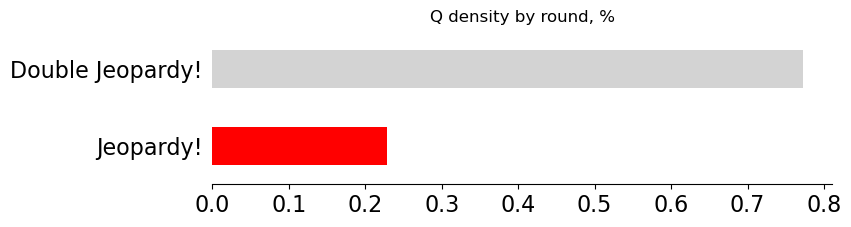

In [35]:
fig, ax = plt.subplots(figsize=(8,2))
rounds.plot.barh(color=['r','lightgray'])
ax.set_title('Q density by round, %')
ax.set_xlabel(None)
ax.tick_params(axis='both', labelsize=16, left=False)
sns.despine(left=True)
plt.show()

Apparently,there are no big prizes in the final round.

In [36]:
jeo_6[jeo_6['round']=='Final Jeopardy!']['big_prize'].value_counts(dropna=False)

0    3631
Name: big_prize, dtype: int64

In [37]:
def find_top_20_cat(df):
    '''Takes in a dataframe and returns the TOP20 categories by frequency,
    both in % and in absolute values.
    '''
    top_20_cat_abs = df['category'].value_counts()[:20].sort_values()
    #list of 20 top cats and their counts, from smallest to largest
    
    top_20_cat_pct = round(top_20_cat_abs*100/sum(df['category'].value_counts()),3)
    return top_20_cat_pct, top_20_cat_abs

big_jeo = jeo_6[jeo_6['big_prize']==1]

jeo_jeo = jeo_6[jeo_6['round']=='Jeopardy!']
big_jeo_jeo = jeo_jeo[jeo_jeo['big_prize']==1]

jeo_double = jeo_6[jeo_6['round']=='Double Jeopardy!']
big_jeo_double = jeo_double[jeo_double['big_prize']==1]

jeo_final = jeo_6[jeo_6['round']=='Final Jeopardy!']
# Extracting the TOP20 categories by frequency in %

top20_cat_pct_all = find_top_20_cat(big_jeo)[0]
top20_cat_pct_jeo = find_top_20_cat(big_jeo_jeo)[0]
top20_cat_pct_double = find_top_20_cat(big_jeo_double)[0]
top20_cat_pct_final = find_top_20_cat(jeo_final)[0]

In [38]:
all_dfs = [top20_cat_pct_all,top20_cat_pct_jeo,top20_cat_pct_double,top20_cat_pct_final]
for i in all_dfs:
    print(i.values)
    print(i.sum())
    print('---')

[0.112 0.116 0.124 0.127 0.13  0.134 0.137 0.137 0.138 0.143 0.145 0.145
 0.147 0.148 0.148 0.158 0.166 0.204 0.215 0.342]
3.116
---
[0.093 0.093 0.093 0.1   0.1   0.107 0.107 0.107 0.107 0.114 0.114 0.121
 0.121 0.129 0.129 0.143 0.157 0.157 0.186 0.264]
2.542
---
[0.137 0.139 0.143 0.143 0.148 0.148 0.16  0.162 0.167 0.169 0.169 0.171
 0.173 0.173 0.173 0.183 0.205 0.245 0.247 0.422]
3.677
---
[0.413 0.413 0.468 0.468 0.468 0.468 0.468 0.523 0.523 0.523 0.523 0.633
 0.661 0.661 0.661 0.716 0.744 0.854 0.936 1.377]
12.501
---


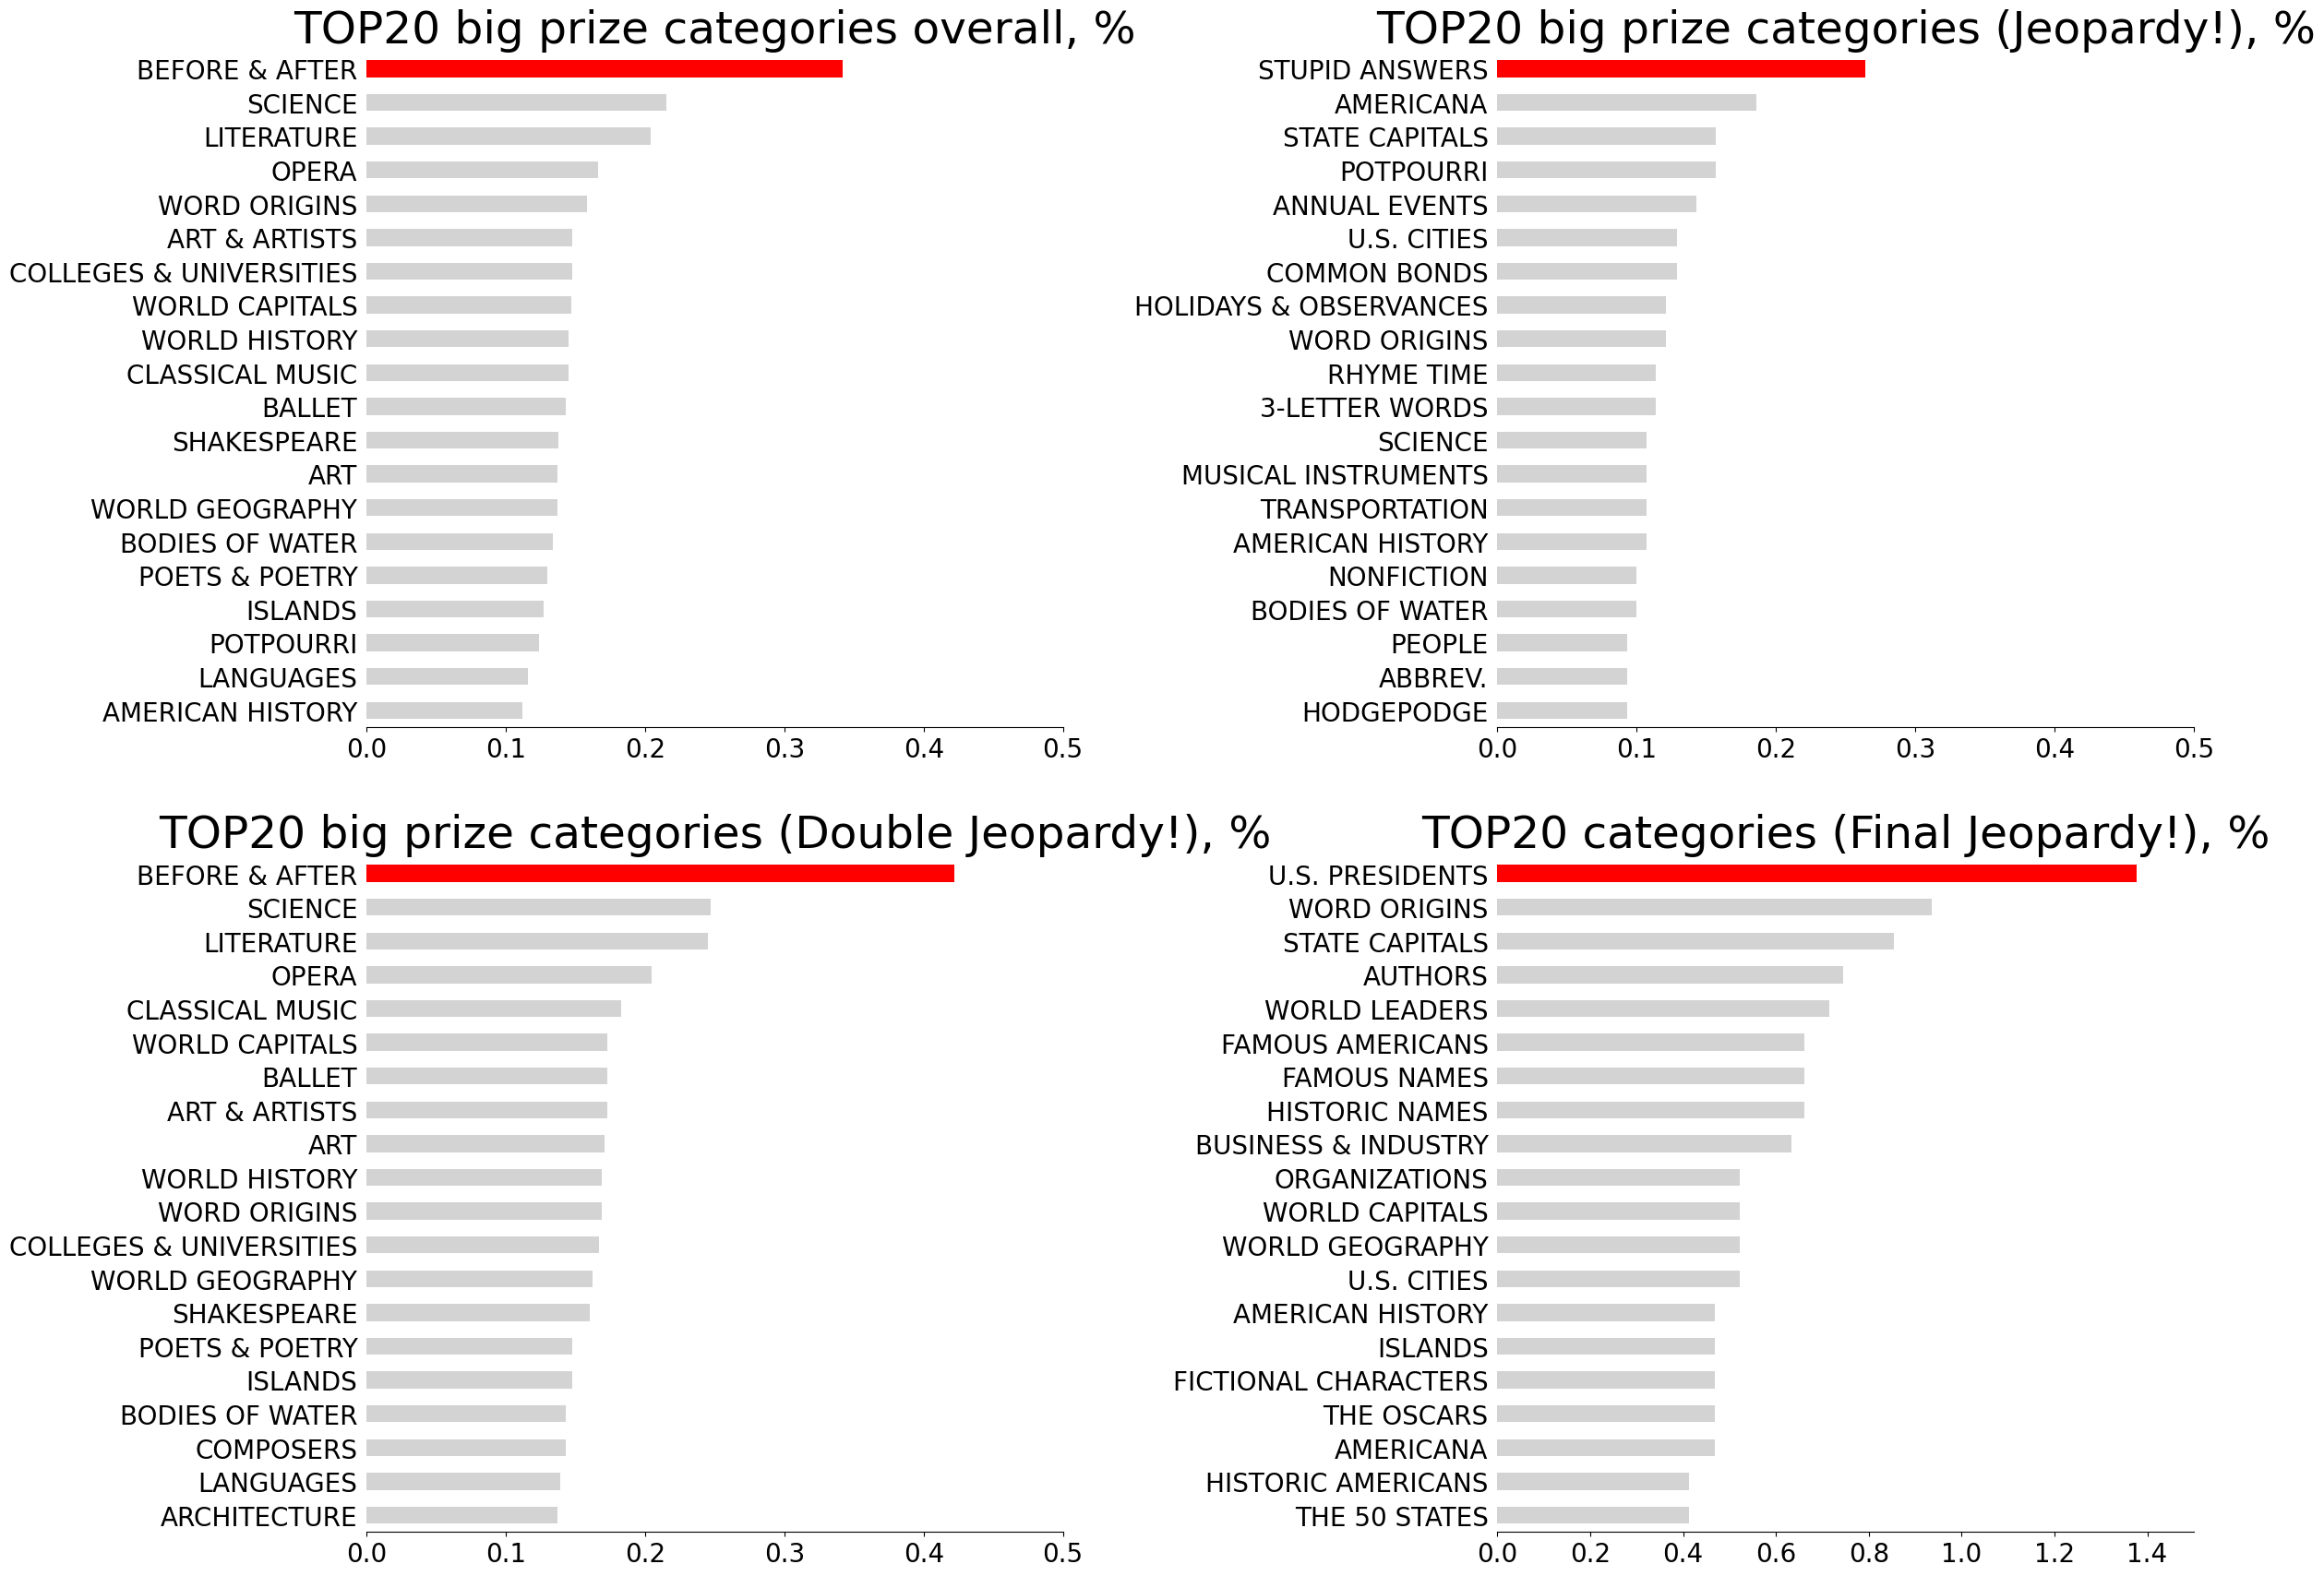

In [39]:

titles = ['TOP20 big prize categories overall, %',
          'TOP20 big prize categories (Jeopardy!), %',
          'TOP20 big prize categories (Double Jeopardy!), %',
          'TOP20 categories (Final Jeopardy!), %']

fig = plt.figure(figsize=(25, 18))
for i in range(0,4):
    ax=fig.add_subplot(2,2,i+1) 
    all_dfs[i].plot.barh(color=
    ['lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray',
    'lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray', 'r'])
    ax.set_title(titles[i], fontsize=35)
    if i == 3:
        ax.set_xlim(0,1.5)
    else:
        ax.set_xlim(0,0.5)
    ax.tick_params(axis='both', labelsize=20, left = False)
    sns.despine(left=True)
    plt.tight_layout(pad=4) 
plt.show()

As the previous approach, we run into the metadata problem of there being just way too many values our variable can assume. Our top20 analysis is generally only valid for 3% of each round, except for the final round, where it contains 12% of all the data. 

In the end, we tried multiple approaches, but our current knowledge is very limited to tackle this issue (surprise, surprise, new learners of python can't crack the code of a consolidated millionaire TV show).

## 7. Conclusion<a name="section7"></a>

It is a frustrating project overall. We tried to address the following questions:

1. How often the answer can be used for a question?
Approximately 6% of answers can be used for a question, which is not very promising when trying to point out what one should study.

2. How often questions are repeated?

Despite 33 out of the 50 most used terms presenting significant difference in use between big prize and small prize questions (25 more present proportionally in big prize questions) we couldn't do much with it, given the lack of context inherent to our approach with isolated words and lack of neuro-language processing 

3. Which are the most frequent categories?

Again, we ran into the big data problem, in which there categories are so framented that selecting the most frequent ones would account only for a small share (3%) of all data, not even close to securing a good orientation towards beating the house.

It is reasonable to expect that the current knowledge of new learners of Python would be limited to tackle a millionaire problem. Our tentative, however, amounted to a good lead to what should be further investigated, i.e., the recycling of questions.

Next steps:
* Find a way to eliminate non-informative words better than just removing short words <6 characters
    - Remove words that occurs more than a certain percentage (5%?)
* Use the whole [Jeopardy dataset](https://github.com/jwolle1/jeopardy_clue_dataset)
* Use phrases instead of single words when seeing if there's overlap between questions. Single words do not capture the context.